In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import pandas as pd

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

In [14]:
%matplotlib inline
import os

from xgboost import plot_tree

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams

In [17]:
import shap
from xgboost import plot_importance

# Data Load

In [21]:
origin_df = pd.read_csv("../data/newquant_naver_kospi_data.csv",index_col=['Date'],parse_dates=True)

In [22]:
n_list = [1,3,5,7,10,20,30,60,90]
for n in n_list:
    col_name = 'avg_price'+str(n)

    origin_df[col_name] = origin_df['Close'].rolling(window=n).mean()
    origin_df[col_name] = origin_df[col_name].shift(-n)
    # shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.
    diffs = origin_df[col_name]-origin_df['Close']
    label_name = 'label'+str(n)
    origin_df[label_name] = np.where(diffs>0,1,0)
    

# setting
df = origin_df['2011-01-01':'2020-12-31']
df.dropna(inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'kosATR14',
       'kosATR30', 'kosATR60', 'kosATR90', 'kosADX14', 'kosADX30', 'kosADX60',
       'kosADX90', 'log_return', 'CCI', 'MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10', 'MACD', 'CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'ATR90', 'ub', 'middle', 'lb', 'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90',
       'avg_price1', 'label1', 'avg_price3', 'label3', 'avg_price5', 'label5',
       'avg_price7', 'label7', 'avg_price10', 'label10', 'avg_price20',
       'label20', 'avg_price30', 'label30', 'avg_price60', 'label60',
       'avg_price90', 'label90'],
      dtype='object')

In [61]:
# 가격데이터
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return','Close']
# 기술지표 데이터
feature2_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10', 'MACD', 'CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'ATR90', 'ub', 'middle', 'lb', 'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90']
# 시장지표 데이터
feature3_list = [#'S&P500', 'SOX', 'VIX','KOSPI',
    'kosATR14',
       'kosATR30', 'kosATR60', 'kosATR90', 'kosADX14', 'kosADX30', 'kosADX60',
       'kosADX90']
# 라벨링에 사용할 데이터
feature4_list = ['next_price','next_rtn']
# 기술지표 중 가격 정보가 덜 드러나는 데이터 
feature5_list = ['CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90']
# 기술지표 중 가격 정보가 드러나는 데이터
feature6_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10']
all_x_feature = feature1_list+feature2_list+feature3_list

# 예측 함수 정의

In [97]:

def predict_stock(df, featurelist):

    result = pd.DataFrame(columns=['label','acc'])
    
    labels = []
    accs = []
    X = df[featurelist]

    # Min Max Scaler를 사용해 스케일링
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    for n in n_list:
        label_name = 'label'+str(n)
        y = df[label_name]

        # train test split
        # label별로 비교하기위해 startify x
        X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=1234)
        #print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
        #print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')


        model = XGBClassifier(feature_names = X.columns.to_list())
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)


        labels.append(label_name)
        accs.append(accuracy_score(y_test, y_pred))
        
    result['label'] = labels
    result['acc'] = accs
        
    return result

In [106]:
def feature_explain(label_name,feature_list):
    X = df[feature_list]


    # 설명성을 위해 Min Max Scaler를 사용하지 않음
    #scaler = MinMaxScaler()
    # scaler.fit(X)
    #X_scaled = scaler.transform(X)
    y = df[label_name]

    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=1234)

    # 학습 데이터로 모델을 학습시키기
    model = XGBClassifier(feature_names = X.columns.to_list())
    model.fit(X_train,y_train)

    # 예측하기
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # 평가하기
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy : %.2f%%' %(accuracy * 100.0))
    
    
    from xgboost import plot_importance


    rcParams['figure.figsize'] = 10,10

    model.get_booster().feature_names = list(X.columns)
    plot_importance(model)

    plt.yticks(fontsize = 15)
    plt.show()
    
    # JS 시각화 라이브러리 로드하기
    shap.initjs()

    # SHAP 값으로 모델의 예측을 설명하기
    # 설명체는 LightGBM, CATBoost, scikit-learn 모델을 입력받을 수 있다.

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values,X_train, plot_type='bar')
    
    # 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
    shap.summary_plot(shap_values, X_train)

# 가격데이터 없이 오직 기술 지표 데이터만으로 예측

In [98]:
result= predict_stock(df,feature5_list)

[03:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:31:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be u

In [99]:
result

,label,acc
0,label1,0.540041
1,label3,0.675565
2,label5,0.755647
3,label7,0.839836
4,label10,0.850103
5,label20,0.899384
6,label30,0.928131
7,label60,0.954825
8,label90,0.954825


[03:39:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:39:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 93.43%


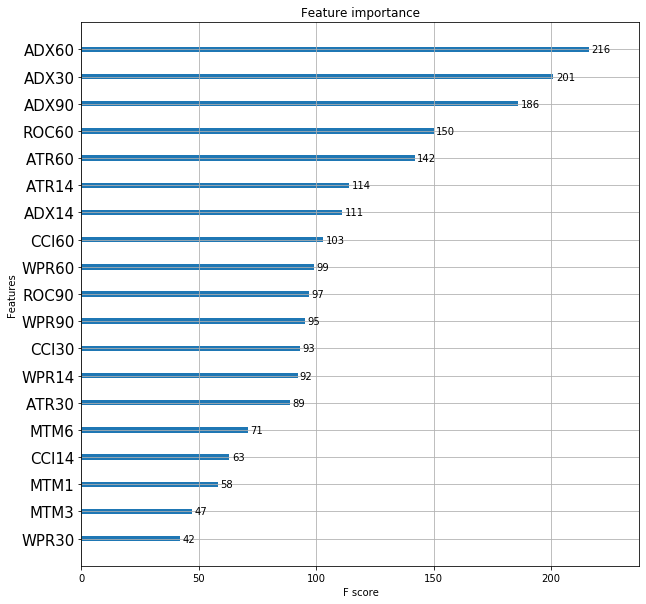

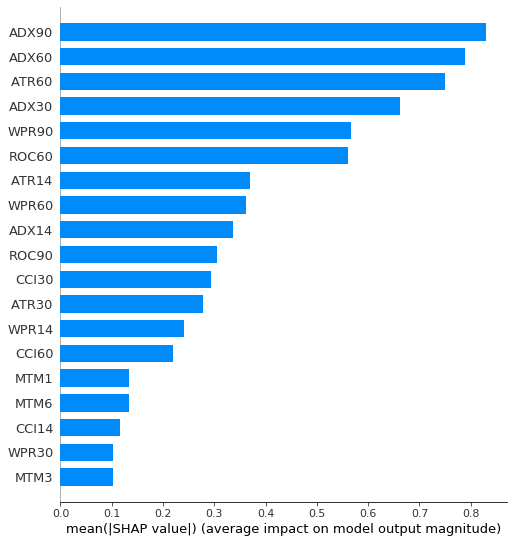

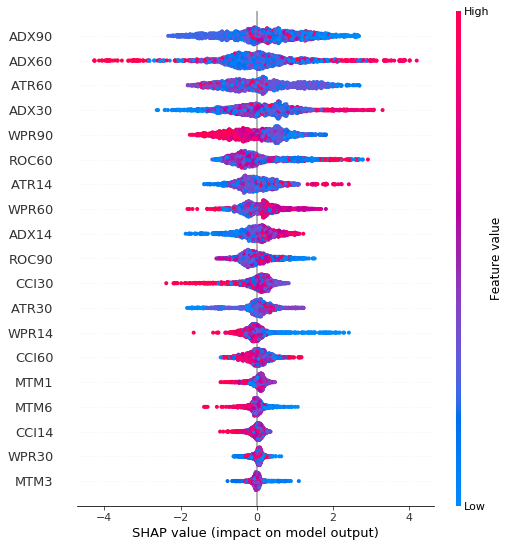

In [107]:
feature_explain('label30',feature5_list)

## 나무모형 시각화 - 깊이 2

[03:38:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:38:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 82.14%


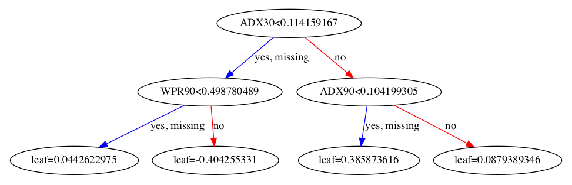

In [104]:
X = df[feature5_list]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)

simple_model = XGBClassifier(max_depth=2,
                            feature_names = X.columns.to_list())

simple_model.fit(X_train,y_train)

# 예측하기
y_pred = simple_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy : %.2f%%' %(accuracy * 100.0))


simple_model.get_booster().feature_names = X.columns.tolist()
plot_tree(simple_model)
plt.show()

# 가격 기술지표 + 시장 기술지표

In [101]:
result1= predict_stock(df,feature5_list+feature3_list)

[03:32:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:32:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:32:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be u

In [102]:
result1

,label,acc
0,label1,0.540041
1,label3,0.673511
2,label5,0.772074
3,label7,0.845996
4,label10,0.860370
5,label20,0.913758
6,label30,0.930185
7,label60,0.958932
8,label90,0.969199


[03:39:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:39:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 94.66%


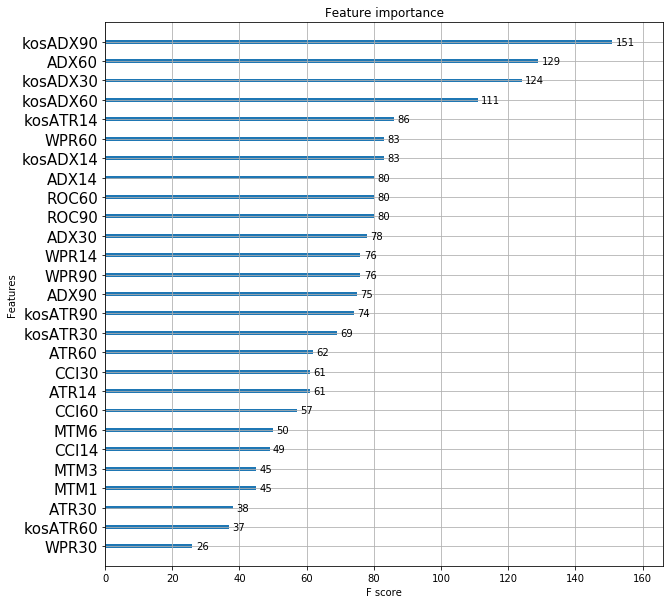

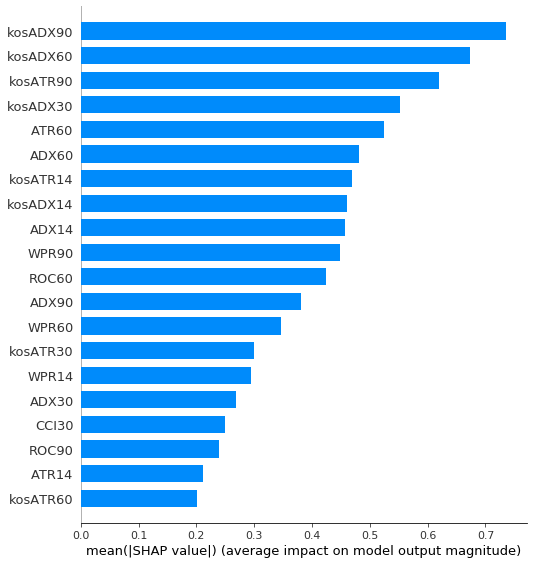

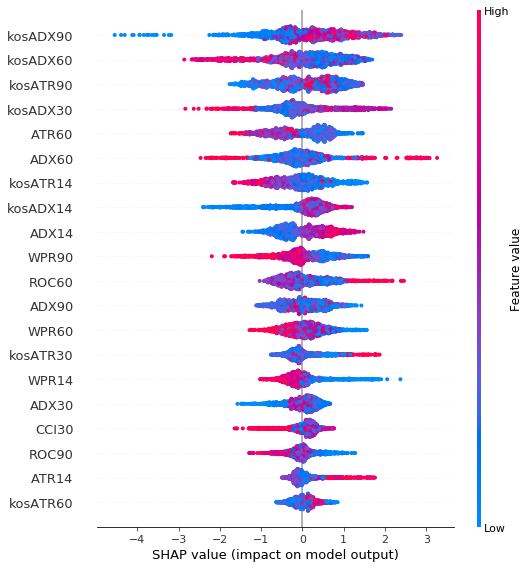

In [108]:
feature_explain('label30',feature5_list+feature3_list)

## 나무모형 시각화 - 깊이 2

[03:38:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:38:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 82.14%


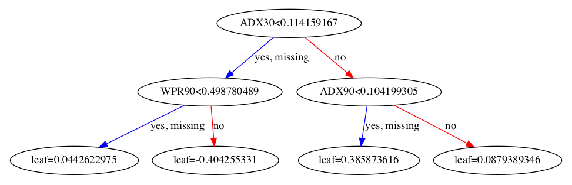

In [105]:
X = df[feature5_list]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=1234)

simple_model = XGBClassifier(max_depth=2,
                            feature_names = X.columns.to_list())

simple_model.fit(X_train,y_train)

# 예측하기
y_pred = simple_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy : %.2f%%' %(accuracy * 100.0))


simple_model.get_booster().feature_names = X.columns.tolist()
plot_tree(simple_model)
plt.show()